In [1]:
%load_ext autoreload
%autoreload complete

In [2]:
from src.data.protests.sources.acled import load_acled

acled = load_acled()
from src.data.news.sources.mediacloud import newspapers_by_region

acled = acled[acled["admin1"].isin(newspapers_by_region.keys())]
climate_actors = [
    "FFF: Fridays for Future",
    "FFF: Fridays for Future; Students (Germany)",
    # "ALG: Uprising of the Last Generation (Germany)",
    # "Extinction Rebellion",
    # "Ende Gelaende",
]
acled = acled[acled["assoc_actor_1"].isin(climate_actors)]
acled = acled[
    (acled["event_date"] >= "2020-07-01") & (acled["event_date"] < "2022-07-01")
]

In [3]:
from src.models.synthetic_region import get_regional_counts_for_protest

df = get_regional_counts_for_protest(
    "klimaschutz",
    list(acled.itertuples())[0],
    acled,
    n_days=7 * 4 * 6,
    source="mediacloud",
)
df = df.pivot(index="date", columns="region", values="count")
df.sample(5)

region,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen
date,,,,,,,,,,,,,,
2022-09-24,15,4,1,0,5,38,5,24,5,2,3,0,2,0
2022-04-02,10,4,1,0,0,7,14,17,1,0,2,0,2,0
2022-03-26,47,9,4,1,8,21,33,79,1,1,6,0,5,0
2022-01-05,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2022-09-08,38,19,2,3,10,31,14,38,3,0,5,0,2,0


In [4]:
from src.data.news.sources.dereko import get_scraped_entries

dereko_entries = get_scraped_entries("klimaschutz")

  0%|          | 0/1366818 [00:00<?, ?it/s]

In [5]:
from src.models.synthetic_region import get_regional_counts_for_protest

df = get_regional_counts_for_protest(
    "klimaschutz",
    list(acled.itertuples())[0],
    acled,
    n_days=7 * 4 * 6,
    source="dereko_scrape",
    dereko_entries=dereko_entries,
)
df = df.pivot(index="date", columns="region", values="count").fillna(0)
df.sample(5)

region,Baden-Württemberg,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen
date,,,,,,,,,,,,,,,,
2022-03-27,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-28,13.0,17.0,6.0,8.0,0.0,0.0,18.0,11.0,1.0,58.0,36.0,0.0,3.0,0.0,0.0,0.0
2022-11-01,30.0,111.0,49.0,49.0,0.0,2.0,94.0,7.0,13.0,96.0,18.0,0.0,5.0,0.0,0.0,0.0
2022-02-20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-11,7.0,31.0,5.0,8.0,0.0,3.0,87.0,11.0,6.0,33.0,23.0,0.0,2.0,0.0,0.0,0.0


In [6]:
import pandas as pd
from tqdm.notebook import tqdm

from src.models.synthetic_region import synthetic_region


def evaluate_multiple_protests(term, protests, source="mediacloud", **kwargs):
    metrics_list = []
    agg_df = pd.DataFrame()
    for protest in tqdm(list(protests.itertuples())):
        df = get_regional_counts_for_protest(
            term,
            protest,
            acled,
            n_days=7 * 4 * 6,
            source=source,
            n_protest_free_days=5,
            **kwargs
        )
        if df["count"][df["is_protest_region"]].sum() == 0:
            continue
        metrics, _, count_df = synthetic_region(df)
        metrics_list.append(metrics)
        # make date relative to the protest date
        count_df["date"] = (count_df["date"] - df["date"].median()).dt.days
        agg_df = pd.concat([agg_df, count_df])
    metrics = pd.DataFrame(metrics_list)
    agg_df = agg_df.groupby("date").mean().reset_index()
    return metrics, agg_df

In [7]:
_, mediacloud_agg_df = evaluate_multiple_protests(
    "klimaschutz", acled, source="mediacloud"
)
mediacloud_agg_df.head()

  0%|          | 0/350 [00:00<?, ?it/s]

,date,real,synth_mean,synth_lasso
0,-84,0.810325,0.876991,0.616363
1,-83,0.438764,0.459828,0.442123
2,-82,0.549971,0.565563,0.501231
3,-81,0.751000,0.559149,0.636467
4,-80,0.920429,1.437342,0.959252


<Axes: >

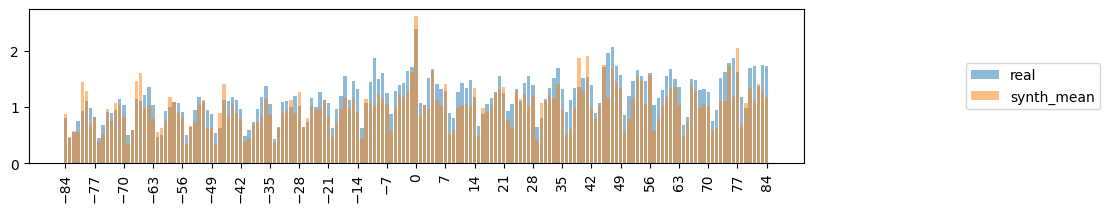

In [8]:
import matplotlib.pyplot as plt

from src.data.news.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 2))
plot_coverage_sequence(
    mediacloud_agg_df.rename(columns={"real": "count"}),
    relative_dates=True,
    ax=ax,
    label="real",
    alpha=0.5,
    show_midpoint=False,
)
plot_coverage_sequence(
    mediacloud_agg_df.rename(columns={"synth_mean": "count"}),
    relative_dates=True,
    ax=ax,
    label="synth_mean",
    alpha=0.5,
    show_midpoint=False,
)

<Axes: >

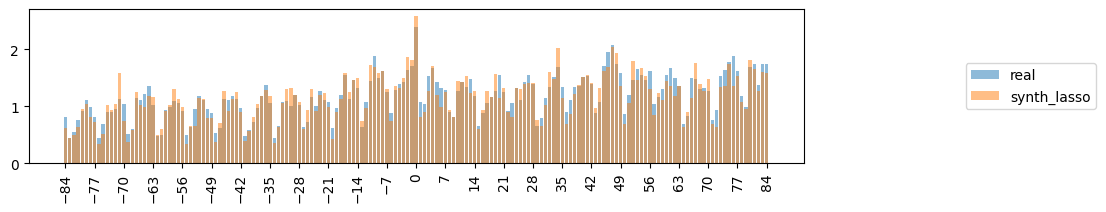

In [9]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_coverage_sequence(
    mediacloud_agg_df.rename(columns={"real": "count"}),
    relative_dates=True,
    ax=ax,
    label="real",
    alpha=0.5,
    show_midpoint=False,
)
plot_coverage_sequence(
    mediacloud_agg_df.rename(columns={"synth_lasso": "count"}),
    relative_dates=True,
    ax=ax,
    label="synth_lasso",
    alpha=0.5,
    show_midpoint=False,
)

In [10]:
_, dereko_agg_df = evaluate_multiple_protests(
    "klimaschutz", acled, "dereko_scrape", dereko_entries=dereko_entries
)
dereko_agg_df.head()

  0%|          | 0/350 [00:00<?, ?it/s]

/Users/david/Repositories/protest-impact/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/david/Repositories/protest-impact/protest_impact/synthetic_region/__init__.py:115: RuntimeWarning: invalid value encountered in divide
  model.coef_ = model.coef_ / model.coef_.sum()


ValueError: Input contains NaN.

<Axes: >

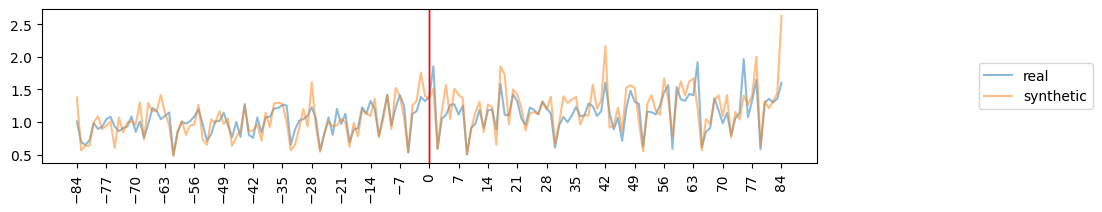

In [ ]:
from src.data.news.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 2))
plot_coverage_sequence(
    dereko_agg_df.rename(columns={"real": "count"}),
    relative_dates=True,
    ax=ax,
    label="real",
    alpha=0.5,
)
# plot_coverage_sequence(dereko_agg_df.rename(columns={"synth_mean": "count"}), relative_dates=True, ax=ax, label="mean", alpha=0.5)
plot_coverage_sequence(
    dereko_agg_df.rename(columns={"synth_lasso": "count"}),
    relative_dates=True,
    ax=ax,
    label="synthetic",
    alpha=0.5,
)

The problem here is that I only keep regions for comparison when there is no protest around the protest event in the core region. These regions tend to be associated with lower protests overall. Better approach is apply the "no protests except at the protest event" criterion to all regions including the core region. This will result in smaller windows.